In [1]:
%matplotlib inline

import tensorflow as tf
import matplotlib.pyplot as plt
import random
import sklearn as sk
from sklearn import decomposition
import numpy as np

# Colab and system related
import os
import time
from google.colab import drive
import sys
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Load MNIST Dataset
mnist = tf.keras.datasets.fashion_mnist
(XTrain, YTrain), (XTest, YTest) = mnist.load_data()
XTrain, XTest = XTrain / 255.0, XTest / 255.0
# Cut out last 100 Training images for comparison
XTrain = XTrain[0:-100]
YTrain = YTrain[0:-100]

4423680/4422102 [==============================] - 0s 0us/step


In [3]:
# Reshape Xtrain and XTest to 1x784 Vectors instead of 28x28 arrays
XTrain = XTrain.reshape((len(XTrain), np.prod(XTrain.shape[1:])))
XTest = XTest.reshape((len(XTest), np.prod(XTest.shape[1:])))

In [4]:
def autoencoder_deep(latent_space_size):
    Input = tf.keras.layers.Input(shape=784)
    h1 = tf.keras.layers.Dense(512, activation='relu')(Input)
    h2 = tf.keras.layers.Dense(256, activation='relu')(h1)
    h3 = tf.keras.layers.Dense(128, activation='relu')(h2)
    encoded = tf.keras.layers.Dense(latent_space_size, activation='linear')(h3)
    # Decoder
    Decoder_Input = tf.keras.layers.Input(shape=latent_space_size)  # Input for Decoder
    h5 = tf.keras.layers.Dense(128, activation='relu')(Decoder_Input)
    h6 = tf.keras.layers.Dense(256, activation='relu')(h5)
    h7 = tf.keras.layers.Dense(512, activation='relu')(h6)
    decoded = tf.keras.layers.Dense(784, activation='sigmoid')(h7)

    # Decouple Encoder and Decoder from overall model
    Encoder = tf.keras.Model(Input, encoded)
    Decoder = tf.keras.Model(Decoder_Input, decoded)
    decoded = Decoder(encoded)
    model = tf.keras.Model(Input, decoded)
    return Encoder, Decoder, model


Encoder, Decoder, model = autoencoder_deep(10)

In [5]:
# Loss Function for Reconstruction of images (i.e. overall Autoencoder)
def loss_fn_AE(y_true, y_pred):
    # y_pred = tf.nn.elu(y_pred) * tf.nn.softplus(y_pred)
    # return tf.losses.categorical_crossentropy(y_true, y_pred)
    # y_pred = tf.nn.softmax(y_pred)
    return  tf.losses.categorical_crossentropy(y_true,y_pred)

In [6]:
# Training Options
model.compile(optimizer='adam',
              #loss=[loss_fn_AE, loss_fn_Encoder],
              loss=loss_fn_AE, 
              metrics=['accuracy'])

# Training and Testing
model.fit(XTrain, XTrain, epochs=10)
model.evaluate(XTest, XTest, verbose=2)

# Save trained Decoder and trained Encoder
Decoder.save('drive/My Drive/masterthesis/modeling/NNs/Fashion-MNIST/pretrained_unsupervised_ae10/Decoder', save_format='tf')
Encoder.save('drive/My Drive/masterthesis/modeling/NNs/Fashion-MNIST/pretrained_unsupervised_ae10/Encoder', save_format='tf')

Epoch 1/10
1872/1872 [==============================] - 27s 14ms/step - loss: 1355.6968 - accuracy: 0.0080
Epoch 2/10
1872/1872 [==============================] - 26s 14ms/step - loss: 1345.7390 - accuracy: 0.0071
Epoch 3/10
1872/1872 [==============================] - 27s 14ms/step - loss: 1343.8866 - accuracy: 0.0062
Epoch 4/10
1872/1872 [==============================] - 26s 14ms/step - loss: 1342.5874 - accuracy: 0.0070
Epoch 5/10
1872/1872 [==============================] - 27s 14ms/step - loss: 1341.6520 - accuracy: 0.0081
Epoch 6/10
1872/1872 [==============================] - 27s 14ms/step - loss: 1340.8735 - accuracy: 0.0090
Epoch 7/10
1872/1872 [==============================] - 27s 15ms/step - loss: 1340.2921 - accuracy: 0.0104
Epoch 8/10
1872/1872 [==============================] - 28s 15ms/step - loss: 1339.8600 - accuracy: 0.0111
Epoch 9/10
1872/1872 [==============================] - 28s 15ms/step - loss: 1339.4871 - accuracy: 0.0119
Epoch 10/10
1872/1872 [==============

No handles with labels found to put in legend.


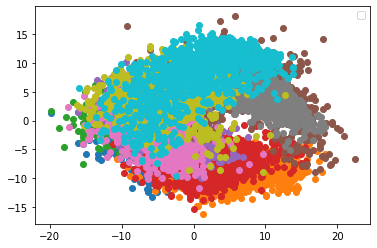

In [7]:
def plot_pca(Encoder, input_data):
    # Get latent space representation (predict samples up to 'bottleneck')
    hidden_rep = Encoder.predict(input_data)

    # For visualization, compute PCA of latent space
    # pca = sk.decomposition.KernelPCA(n_components=10, kernel='linear')
    pca = sk.decomposition.PCA(n_components=10)
    principalComponents = pca.fit_transform(hidden_rep)
    labels = np.linspace(0, 9, 10)

    fig = plt.figure()
    ax = fig.add_subplot(111)#, projection='3d')
    digits = range(0, 10, 1)

    # Plot 3 strongest PCs
    for digit in digits:
        PC1 = principalComponents[np.where(YTest == digit), 0]
        PC2 = principalComponents[np.where(YTest == digit), 1]
        #PC3 = principalComponents[np.where(YTest == digit), 2]

        plot_indices = random.sample(range(0, len(PC1.T)), round(len(PC1.T) / 1))
        ax.scatter(PC1[:, plot_indices],
                   PC2[:, plot_indices])
                   #PC3[:, plot_indices], label=digit)
    plt.legend()


plot_pca(Encoder, XTest)
plt.show()

10000


IndexError: ignored

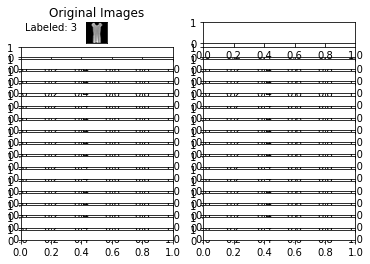

In [8]:
def plot_reconstruction(Encoder, model, input_data, input_data_labels):
    # Plotting reconstructions through autoencoder
    predicted_img = model.predict(input_data)
    predicted_img = np.array(predicted_img[0][:][:])
    print(len(input_data))
    random_image_indices = random.sample(range(len(input_data)), 18)

    fig, ax = plt.subplots(18, 2)
    for i in range(1, 19):
        if i % 2 != 0:
            plt.subplot(9, 2, i)
            plt.imshow(np.reshape(input_data[random_image_indices[i], :], [28, 28]), cmap='gray')
            ax = plt.gca()
            ax.axes.xaxis.set_visible(False)
            ax.axes.yaxis.set_ticks([])
            plt.ylabel('Labeled: {}'.format(input_data_labels[random_image_indices[i]]), fontsize=10, rotation=0,
                       labelpad=35)

        if i % 2 == 0:
            plt.subplot(9, 2, i)
            img = predicted_img[random_image_indices[i - 1]].reshape([28, 28])
            plt.imshow(img, cmap='gray')
            img = img.reshape(784).tolist()
            img_class = Encoder.predict([img[:]])
            img_class = np.array(img_class[0][:])
            img_class = np.where(img_class == np.amax(img_class))
            ax = plt.gca()
            ax.axes.xaxis.set_visible(False)
            ax.axes.yaxis.set_ticks([])
            plt.ylabel('Classified: {}'.format(img_class[0][0]), fontsize=10, rotation=0, labelpad=35)
        if i == 1:
            plt.title('Original Images')
        if i == 2:
            plt.title('Generated Images')
    plt.tight_layout(pad=0.1)


plot_reconstruction(Encoder, model, XTest, YTest)

plt.show()